In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import pickle
import yaml
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
from reaction_predictors.graph_model.models import RGCNNTrClassifier
from utils.graph_utils import get_bonds, get_nodes
from utils.torch_dataset import Dataset, graph_collate
from utils.draw_utils import draw_gt_reaction
from reaction_predictors.graph_model.model_utils import train_epoch, evaluate, test
from collections import namedtuple

RDKit WARNING: [22:52:11] Enabling RDKit 2019.09.3 jupyter extensions


In [4]:
import pickle
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, Image
IPythonConsole.molSize = (400,400)

In [5]:
def prune_dataset_by_length(dataset, max_len):
    new_dataset = {}
    for idx in dataset:
        r_mask = dataset[idx]['reactants']['mask']
        r_mask = r_mask[r_mask > 0]
        if len(dataset[idx]['target_main_product']) <= max_len and len(np.unique(r_mask)) == len(r_mask):
            new_dataset[idx] = dataset[idx]
    return new_dataset

In [6]:
def vizualize_attention(att_map, data):
    print(data["smiles"])
    plt.figure(figsize=(10, 10))
    elems = [num2elem[i] + ':' + str(j) for (i, j) in zip(data["reactants"]["nodes"], data["reactants"]["mask"])]
    n_atoms = len(data["reactants"]["nodes"])
    sn.heatmap(att_map[:n_atoms, :n_atoms], xticklabels=elems, yticklabels=elems)
    plt.show()

In [7]:
def convert(dictionary):
    for key, value in dictionary.items():
        if isinstance(value, dict):
            dictionary[key] = convert(value)
    return namedtuple('GenericDict', dictionary.keys())(**dictionary)

In [8]:
with open('../scripts/graph_models/MT_TBF_sm_vis.yml', 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.FullLoader)

In [9]:
device = 'cuda:2'
model_cfg = convert(config["model"])
data_cfg = convert(config["dataset"])
train_cfg = convert(config["train"])
paths = convert(config["paths"])

In [10]:
meta = pickle.load(open(paths.dataset_path + 'meta.pkl', 'rb'))

node2label = get_nodes(meta['node'], n_molecule_level=data_cfg.n_molecule_level,
                       n_reaction_level=data_cfg.n_reaction_level)
bond2label = get_bonds(meta['type'], n_molecule_level=data_cfg.n_molecule_level,
                       n_reaction_level=data_cfg.n_reaction_level,
                       self_bond=data_cfg.self_bond)

In [11]:
num_rels = len(bond2label)
pad_length = data_cfg.max_num_atoms + 15 * data_cfg.n_molecule_level + \
             data_cfg.n_molecule_level * data_cfg.n_reaction_level
num_nodes = pad_length

In [12]:
model =torch.load(paths.save_path)
model = model.to(device)

In [13]:
test_dataset = pickle.load(open(paths.dataset_path + 'test.pkl', 'rb'))
test_dataset = prune_dataset_by_length(test_dataset, data_cfg.max_num_atoms)
ts_dataset = Dataset(test_dataset, device=device, pad_length=pad_length,
                         bond2label=bond2label, node2label=node2label, feature_idxs=data_cfg.feature_idxs,
                         target_main_product=data_cfg.target_main_product, target_center=data_cfg.target_center,
                         n_molecule_level=data_cfg.n_molecule_level, n_reaction_level=data_cfg.n_reaction_level)
test_loader = DataLoader(ts_dataset, train_cfg.batch_size, drop_last=True, collate_fn=graph_collate)

In [14]:
elements = "H He Li Be B C N O F Ne Na Mg Al Si P S Cl Ar K Ca Sc Ti V Cr Mn Fe Co Ni Cu Zn Ga Ge As Se Br Kr Rb Sr Y Zr Nb Mo Tc Ru Rh Pd Ag Cd In Sn Sb Te I Xe Cs Ba La Ce Pr Nd Pm Sm Eu Gd Tb Dy Ho Er Tm Yb Lu Hf Ta W Re Os Ir Pt Au Hg Tl Pb Bi Po At Rn Fr Ra Ac Th Pa U Np Pu Am Cm Bk Cf Es Fm Md No Lr Rf Db Sg Bh Hs Mt Ds Rg Cn Uut Fl Uup Lv Uus Uuo".split()
num2elem = dict(zip(range(1, len(elements)+1), elements))
elem2num = dict(zip(elements, range(1, len(elements)+1)))

In [15]:
model.eval()
attentions = []
in_hiddens = []
out_hiddens = []
with torch.no_grad():
    for batch in test_loader:
        g = batch[0]
        h = model.embed(g.ndata['feats'].T)
        g.ndata['h'] = h
        h = model.rgcn(g).view((model.batch_size, model.n_nodes, model.h_dim))
        in_hiddens.append(h.cpu().detach().numpy())
        h = h.permute(1, 0, 2)
        attentions.append(model.trans.layers[0].self_attn(h, h, h)[1].cpu().detach().numpy())
        out_hiddens.append(model.trans.layers[0].self_attn(h, h, h)[0].permute(1, 0, 2).cpu().detach().numpy())
att_maps = np.concatenate(attentions)
out_hs = np.concatenate(out_hiddens)
in_hs = np.concatenate(in_hiddens)

In [16]:
id2map = dict(zip(test_dataset.keys(), att_maps))
id2out = dict(zip(test_dataset.keys(), out_hs))
id2in = dict(zip(test_dataset.keys(), in_hs))

In [17]:
idx = 9

In [19]:
pic1, pic2 = draw_gt_reaction(test_dataset[idx])

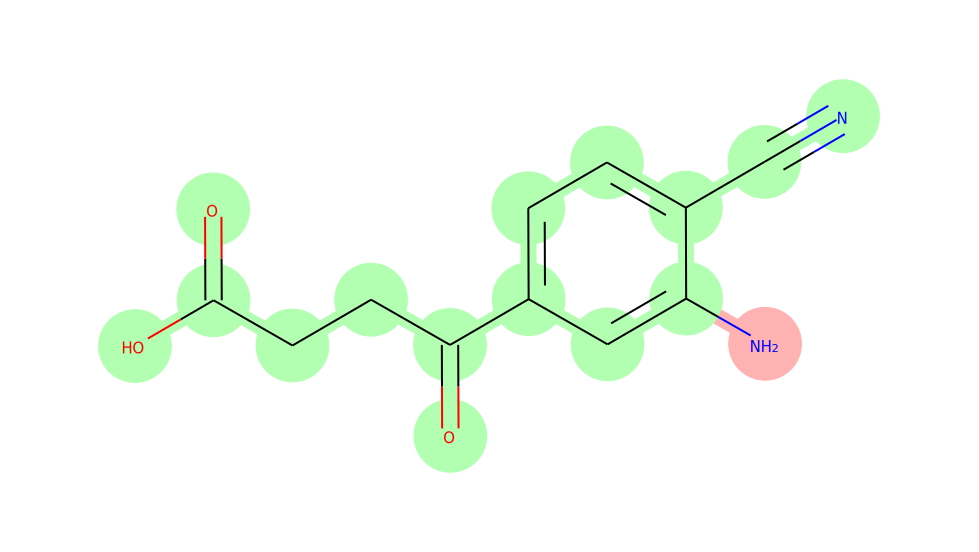

In [20]:
SVG(pic1)

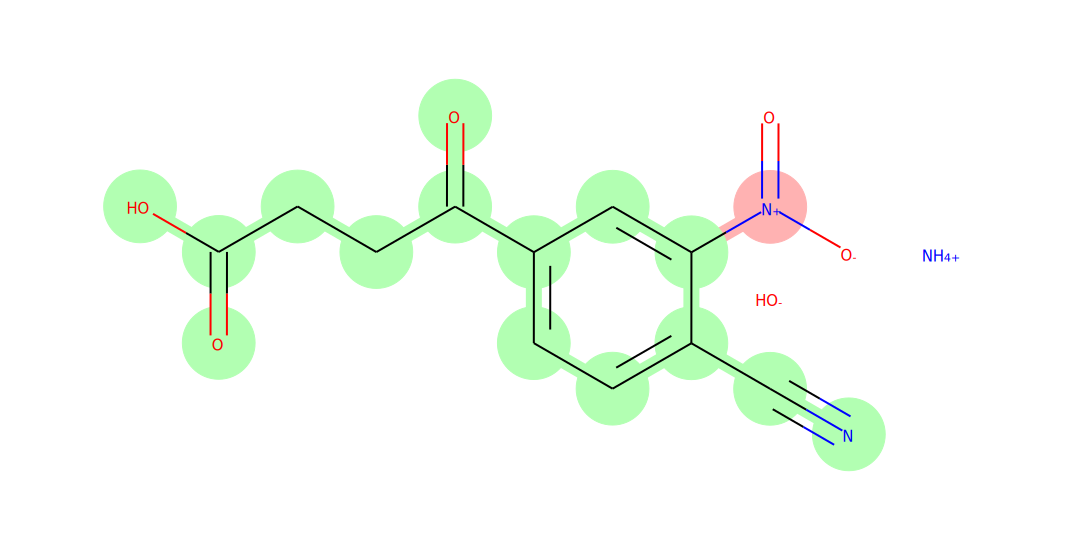

In [21]:
SVG(pic2)

N#Cc1ccc(C(=O)CCC(=O)O)cc1[N+](=O)[O-]>[NH4+].[OH-]>N#Cc1ccc(C(=O)CCC(=O)O)cc1N


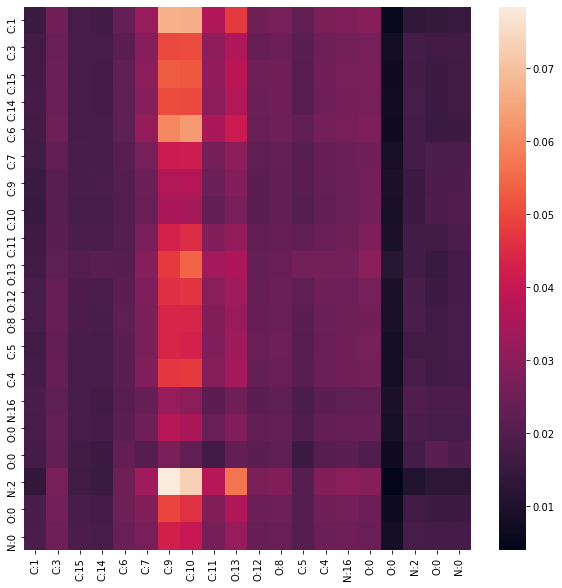

In [22]:
vizualize_attention(id2map[idx], test_dataset[idx])

N#Cc1ccc(C(=O)CCC(=O)O)cc1[N+](=O)[O-]>[NH4+].[OH-]>N#Cc1ccc(C(=O)CCC(=O)O)cc1N


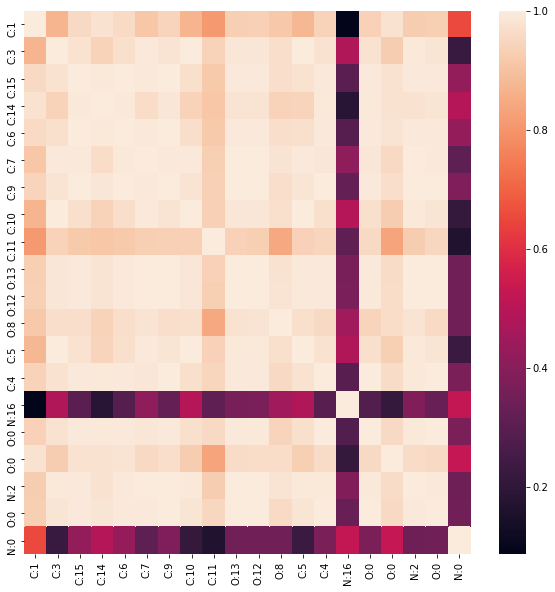

In [23]:
vizualize_attention(np.abs(np.corrcoef(id2out[idx].T)), test_dataset[idx])

/home/socrates/miniconda3/envs/chem/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/socrates/miniconda3/envs/chem/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


N#Cc1ccc(C(=O)CCC(=O)O)cc1[N+](=O)[O-]>[NH4+].[OH-]>N#Cc1ccc(C(=O)CCC(=O)O)cc1N


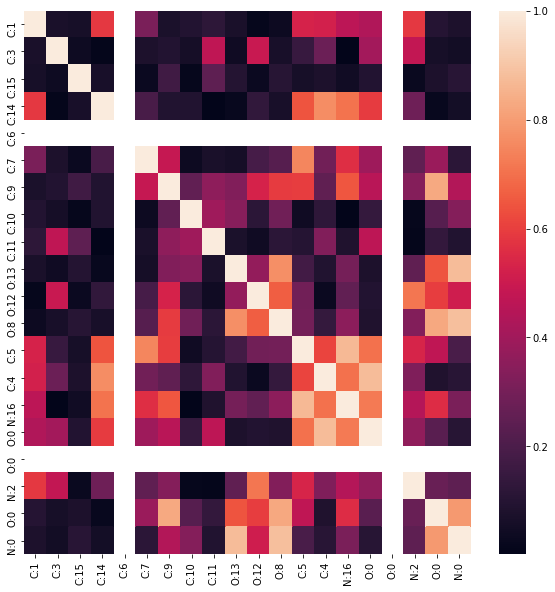

In [24]:
vizualize_attention(np.abs(np.corrcoef(id2in[idx].T)), test_dataset[idx])

N#Cc1ccc(C(=O)CCC(=O)O)cc1[N+](=O)[O-]>[NH4+].[OH-]>N#Cc1ccc(C(=O)CCC(=O)O)cc1N


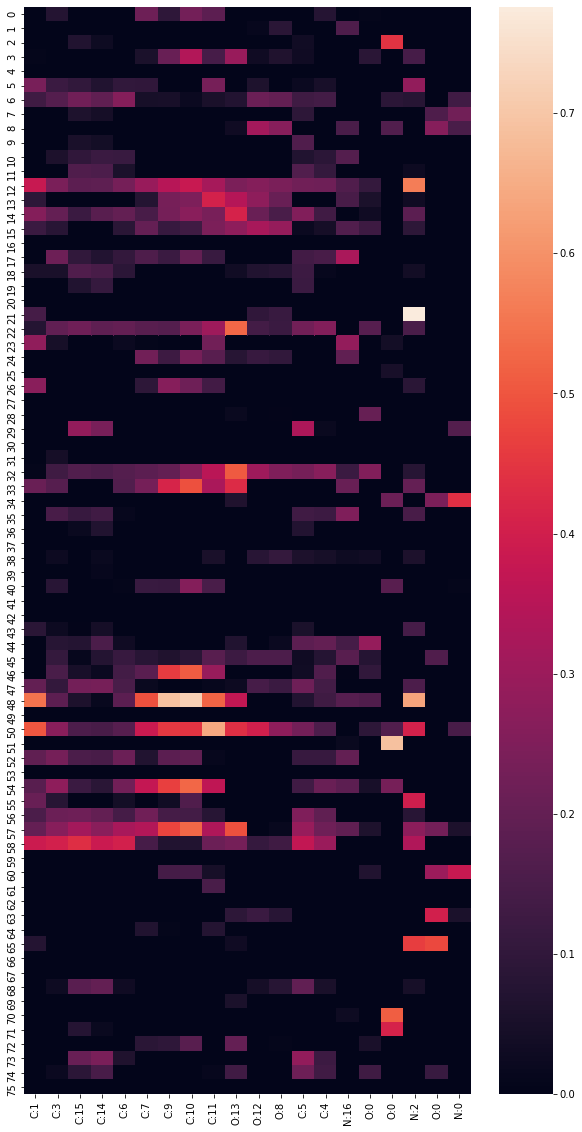

In [25]:
data = test_dataset[idx]
in_map = id2in[idx]
print(data["smiles"])
plt.figure(figsize=(10, 20))
elems = [num2elem[i] + ':' + str(j) for (i, j) in zip(data["reactants"]["nodes"], data["reactants"]["mask"])]
n_atoms = len(data["reactants"]["nodes"])
sn.heatmap(in_map[:n_atoms, :].T, xticklabels=elems)
plt.show()

N#Cc1ccc(C(=O)CCC(=O)O)cc1[N+](=O)[O-]>[NH4+].[OH-]>N#Cc1ccc(C(=O)CCC(=O)O)cc1N


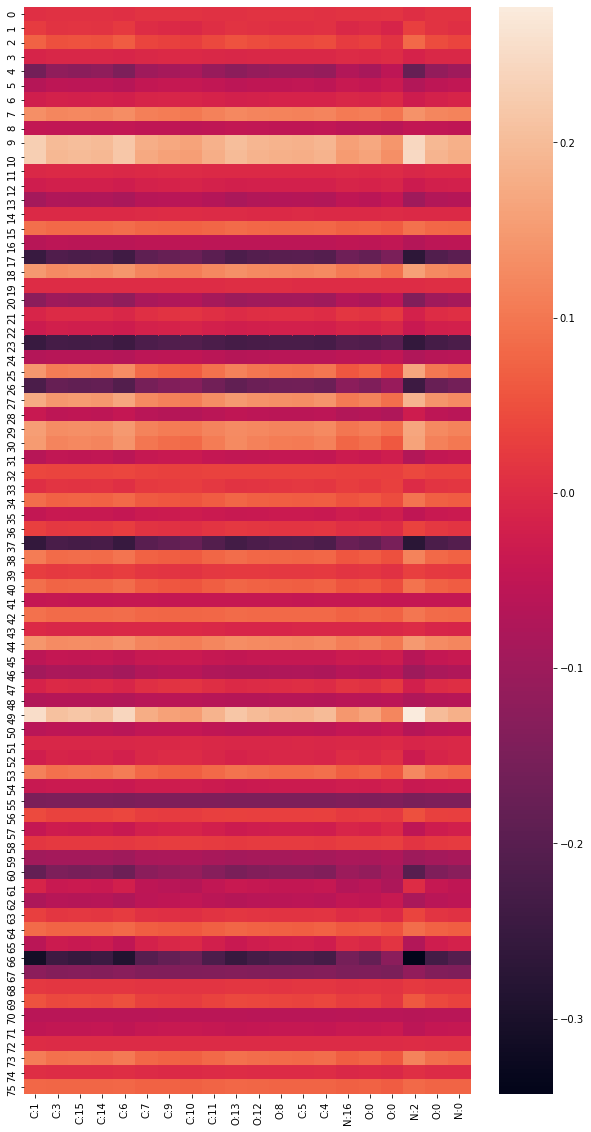

In [26]:
data = test_dataset[idx]
out_map = id2out[idx]
print(data["smiles"])
plt.figure(figsize=(10, 20))
elems = [num2elem[i] + ':' + str(j) for (i, j) in zip(data["reactants"]["nodes"], data["reactants"]["mask"])]
n_atoms = len(data["reactants"]["nodes"])
sn.heatmap(out_map[:n_atoms, :].T, xticklabels=elems)
plt.show()

N#Cc1ccc(C(=O)CCC(=O)O)cc1[N+](=O)[O-]>[NH4+].[OH-]>N#Cc1ccc(C(=O)CCC(=O)O)cc1N


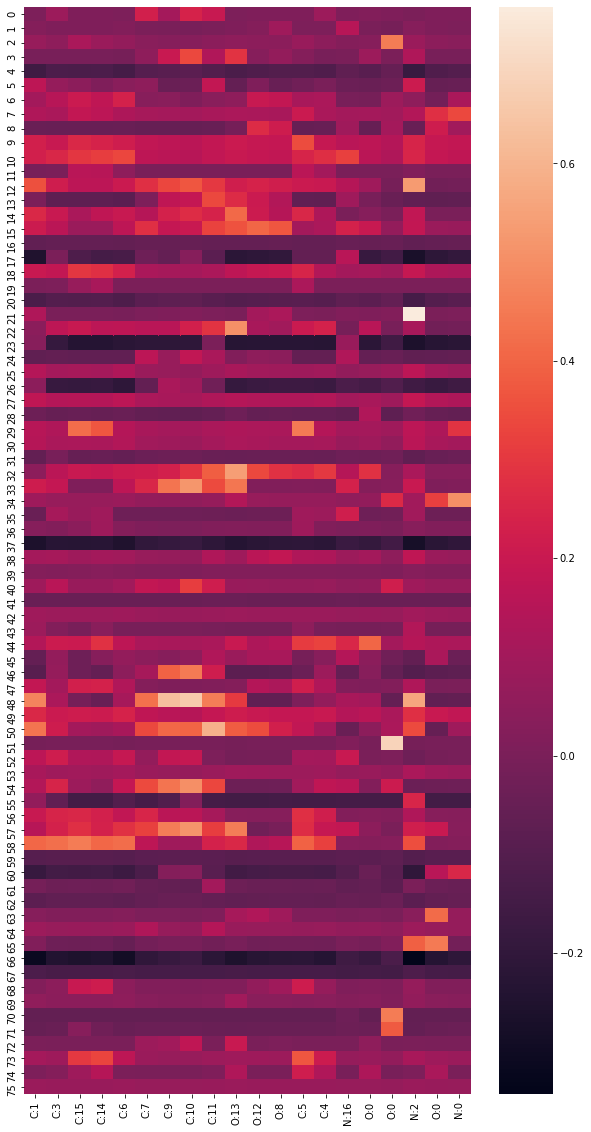

In [27]:
print(data["smiles"])
plt.figure(figsize=(10, 20))
elems = [num2elem[i] + ':' + str(j) for (i, j) in zip(data["reactants"]["nodes"], data["reactants"]["mask"])]
n_atoms = len(data["reactants"]["nodes"])
sn.heatmap(in_map[:n_atoms, :].T + out_map[:n_atoms, :].T, xticklabels=elems)
plt.show()